<a href="https://colab.research.google.com/github/cagBRT/computer-vision/blob/master/CV5_Yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Need to upload yolov3.weights - it is too big for github**<br>
The upload could take as long as 13 minutes.

In [1]:
! wget "https://pjreddie.com/media/files/yolov3.weights"

--2023-11-22 15:13:29--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  67.9MB/s    in 3.7s    

2023-11-22 15:13:33 (63.2 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [2]:
!git clone -l -s https://github.com/cagBRT/computer-vision.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 3884, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 3884 (delta 107), reused 106 (delta 59), pack-reused 3689
Receiving objects: 100% (3884/3884), 421.79 MiB | 37.88 MiB/s, done.
Resolving deltas: 100% (1442/1442), done.
Updating files: 100% (2300/2300), done.
/content/cloned-repo
apple-256261_640.jpg			       instance-segmentation
apple-256261_640UpsideDown.jpg		       landscape1.jpg
cat.png					       landscape2.jpg
CV10_InstanceSegmentation.ipynb		       landscape3.jpg
CV1_ObjectLocalization.ipynb		       landscape4.jpg
CV2_Object_Detection.ipynb		       modelOut
CV3_faceDetection.ipynb			       opencv10a.ipynb
CV4_Advanced_ContentBasedImageRetrieval.ipynb  opencv10.ipynb
CV5_Yolov3.ipynb			       opencv1.ipynb
CV6_ObjectRecognition.ipynb		       opencv2.ipynb
CV7a_ImageSegmenation.ipynb		       opencv3.ipynb
CV7b_RegionBasedSegmentation.ipynb	       op

# **YOLOv3 Architecture**
YOLO is not the most accurate algorithm. RetinaNet, and SSD outperform it in terms of accuracy. <br>

It is still, however, was one of the fastest.<br>

But that speed has been traded off for boosts in accuracy in YOLO v3. While the earlier variant ran on 45 FPS on a Titan X, the current version clocks about 30 FPS. This has to do with the increase in complexity of underlying architecture called Darknet.

YOLO looks at the image once, instead of many times. The image is divided into a grid. Each cell in the grid can predict 2 bounding boxes. <br>
The bounding boxes are drawn for each object detected (upper center image). This can result in many bounding boxes. The heavier the box lines the higher the confidence in the prediction. <br>
The highest confidence boxes that have little overlap are kept.

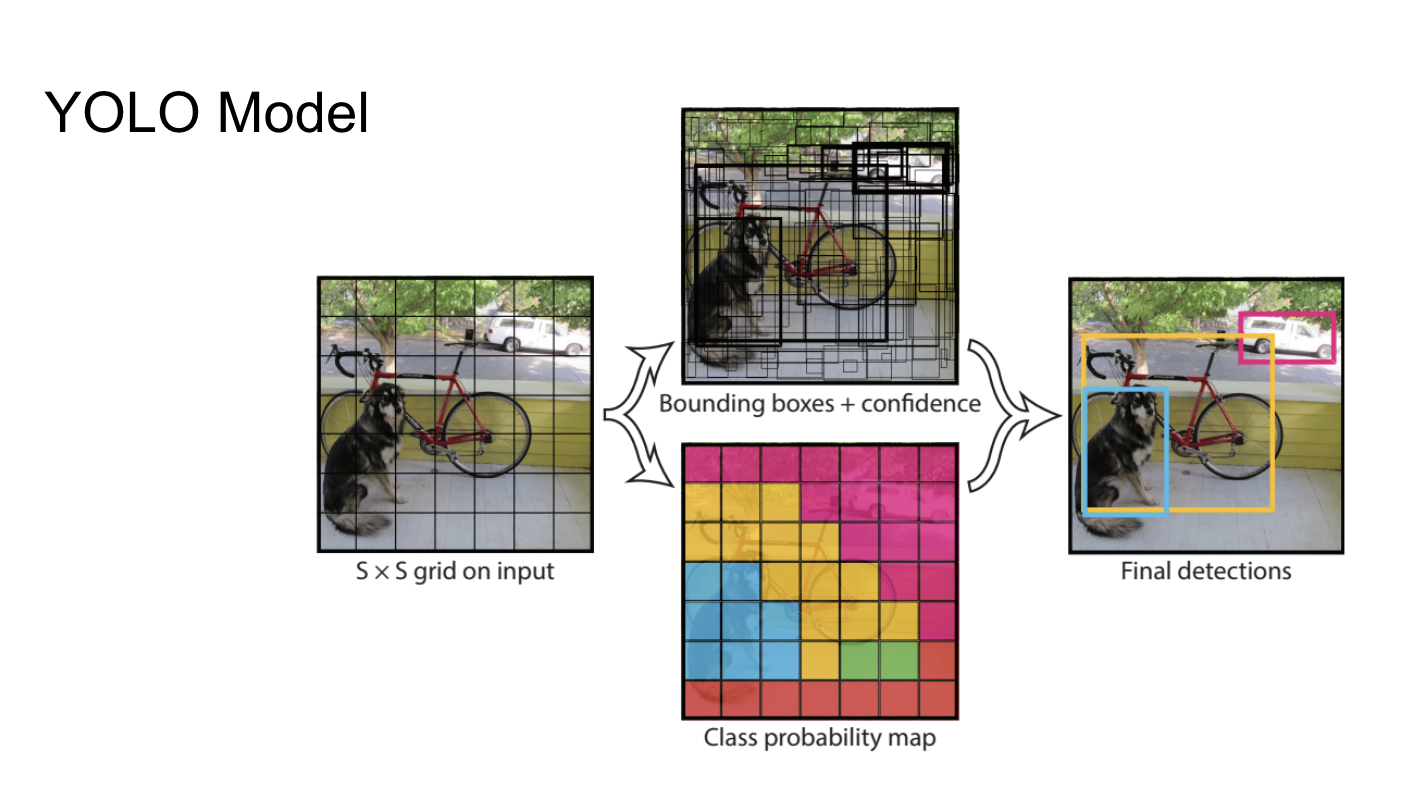

In [3]:
from IPython.display import Image
Image("images/YOLOGrids.png", width=640)

# **Darknet-53**
YOLO v3 uses a variant of Darknet, which originally had a 53 layer network trained on Imagenet. For the task of detection, 53 more layers are stacked onto it, giving us a **106 layer fully convolutional underlying architecture for YOLO v3**. <br>
This is the reason behind the slowness of YOLO v3 compared to YOLO v2.

*The most salient feature of v3 is that it makes detections at three different scales.*

Which are precisely given by downsampling the dimensions of the input image by 32, 16 and 8 respectively.

The 13 x 13 layer is responsible for detecting large objects, whereas the 52 x 52 layer detects the smaller objects, with the 26 x 26 layer detecting medium objects.

https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b

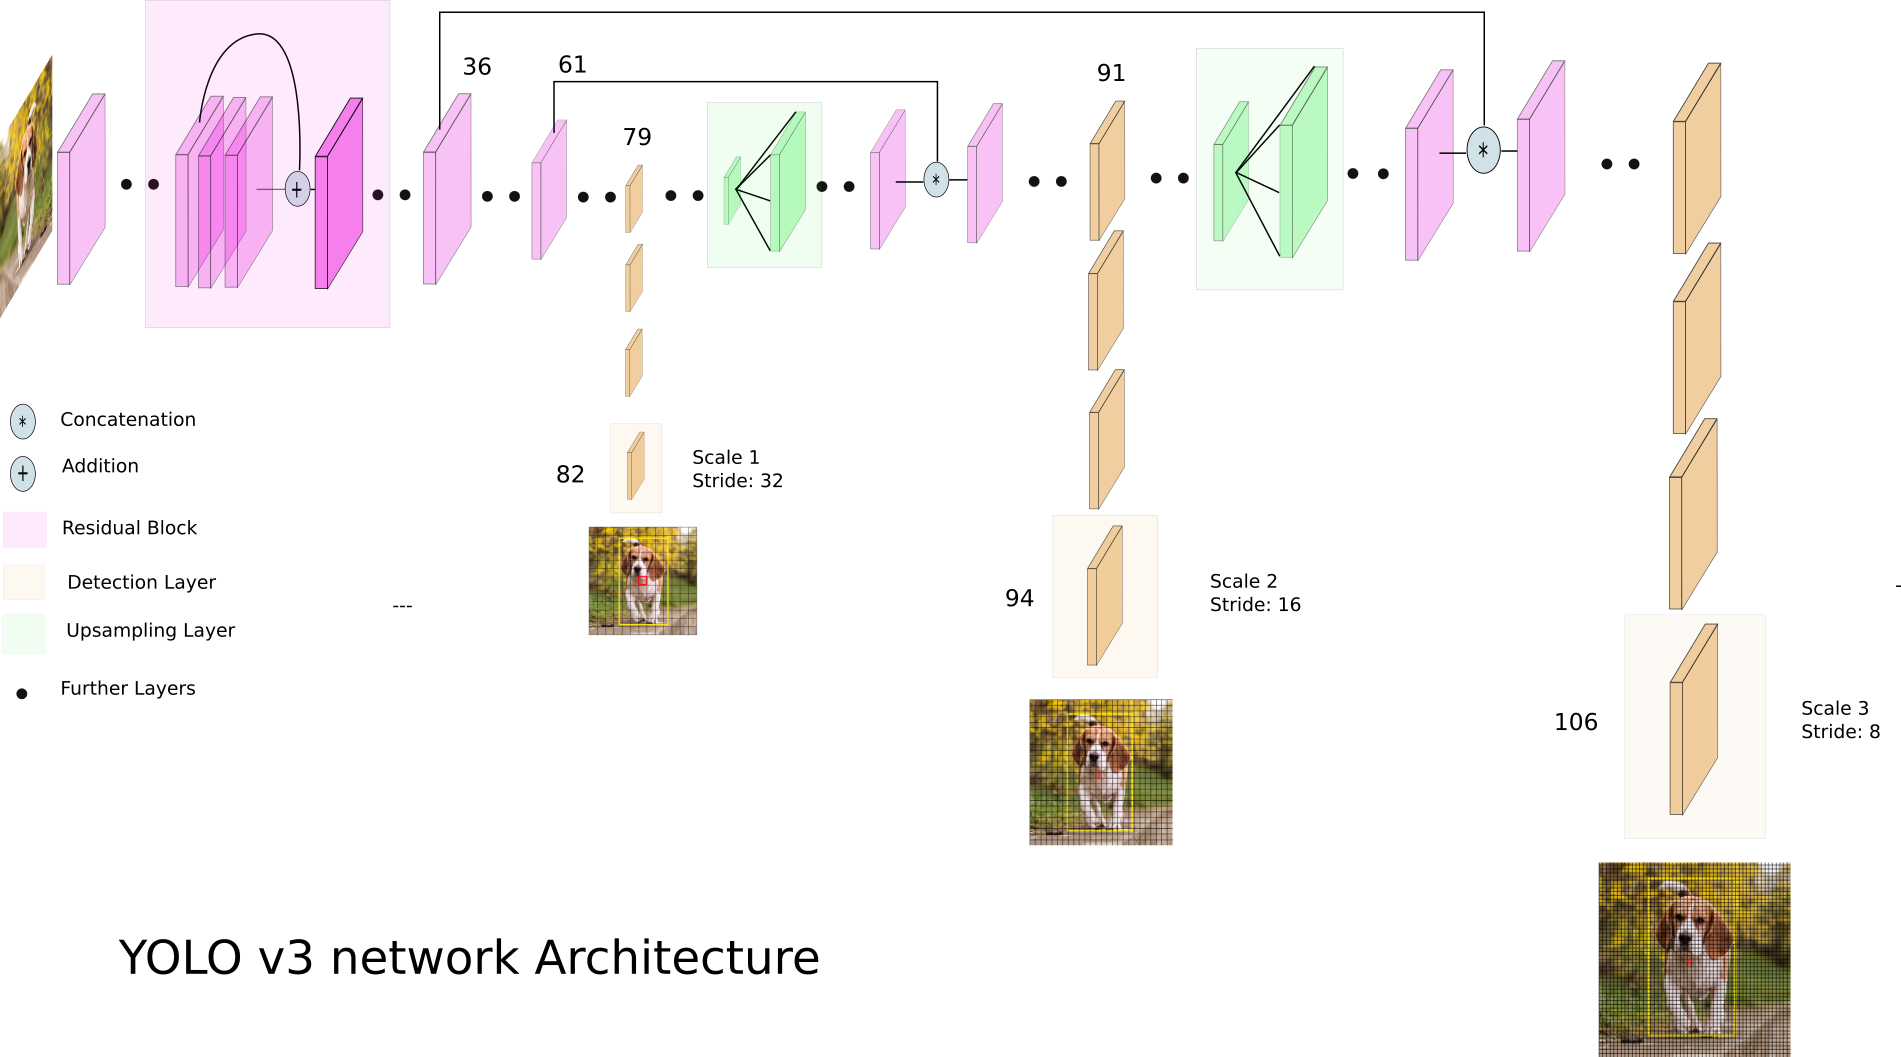

In [4]:
from IPython.display import Image
Image("images/YOLO3architecture.png", width=640)

**YOLOv3 does not use Softmax**<br>
YOLO v3 performs multilabel classification for objects detected in images.
Earlier in YOLO, authors used to softmax the class scores and take the class with maximum score to be the class of the object contained in the bounding box. <br>

Softmaxing classes assumes classes are mutually exclusive, or in simple words, if an object belongs to one class, then it cannot belong to the other. This works fine in COCO dataset.<br>
However, when we have classes like Person and Women in a dataset, then the  assumption fails. <br>

This is the reason why the authors of YOLO have refrained from softmaxing the classes. Instead, each class score is predicted using logistic regression and a threshold is used to predict multiple labels for an object. Classes with scores higher than this threshold are assigned to the box.

The object's centroid is in the red grid, which means it is responsible for detecting the dog. <br>
The feature vector lists:<BR>
- the coordinates of the bounding box
- the confidence score of the object
- the class scores for all the classes in the set

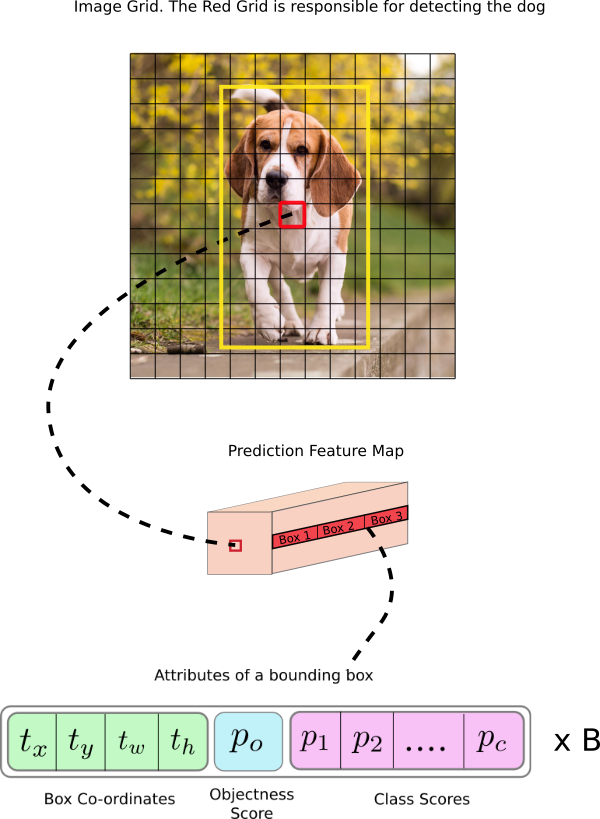

In [5]:
from IPython.display import Image
Image("images/YOLOOutputVector.png", width=640)

The simplified architecture is:
- image input
- image is overlaid with a grid
- each cell produces the coordinates, the confidence score, and the class probabilities

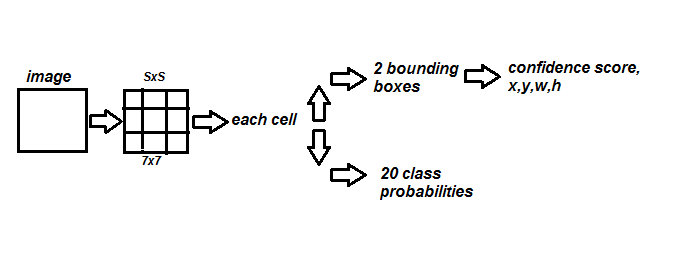

In [6]:
Image("images/outputVector.png", width=640)

**Anchor boxes**<br>
Both Faster R-CNN and YOLO use anchor boxes to improve object detection. <br>
Anchor boxes are pre-defined bounding boxes with useful shapes and sizes that are tailored during training. <br>
Anchor boxes shape and size is determined by the training data. Using a K-Means clustering algorithm, the training set is clustered by the size and location of the objects in the training images. These clusters determine the box size an shape.

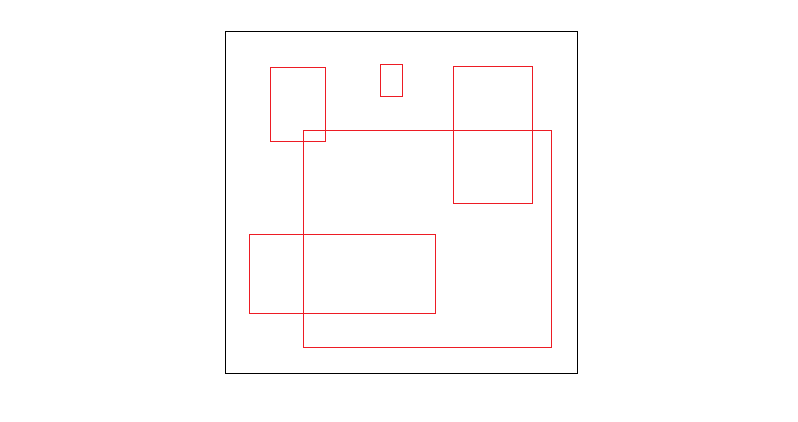

In [7]:
Image("images/KMeansBoxes.png", width=640)

The anchor boxes are then used to detect objects in the image. <br>
In the example below the two dotted black boxes are anchor boxes for the cell. The yellow and blue boxes are the output boxes.

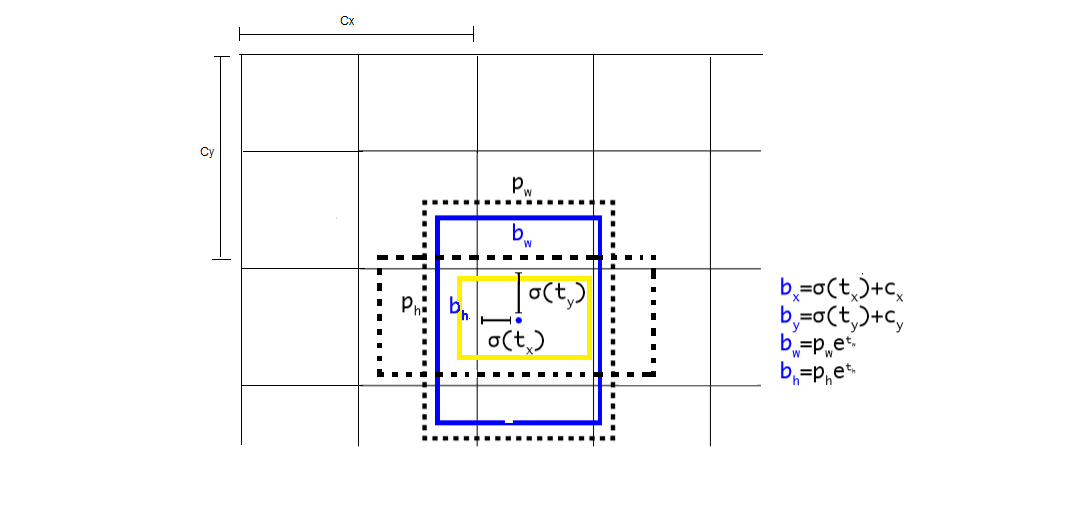

In [8]:
Image("images/anchorBoxes.png", width=640)

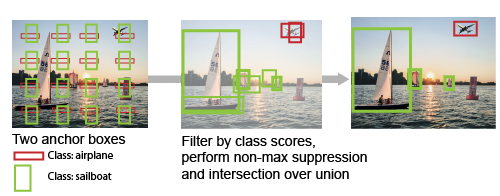

In [9]:
Image("images/labelBoxesExample.png", width=640)

Underneath it uses YOLOv3 model trained on [COCO dataset](https://cocodataset.org/#home) capable of detecting 80 common objects in context.
The common objects are:<br>
person,
bicycle,
car,
motorcycle,
airplane,
bus,
train,
truck,
boat,
traffic light,
fire hydrant,
stop sign,
parking meter,
bench,
bird,
cat,
dog,
horse,
sheep,
cow,
elephant,
bear,
zebra,
giraffe,
backpack,
umbrella,
handbag,
tie,
suitcase,
frisbee,
skis,
snowboard,
sports ball,
kite,
baseball bat,
baseball glove,
skateboard,
surfboard,
tennis racket,
bottle,
wine glass,
cup,
fork,
knife,
spoon,
bowl,
banana,
apple,
sandwich,
orange,
broccoli,
carrot,
hot dog,
pizza,
donut,
cake,
chair,
couch,
potted plant,
bed,
dining table,
toilet,
tv,
laptop,
mouse,
remote,
keyboard,
cell phone,
microwave,
oven,
toaster,
sink,
refrigerator,
book,
clock,
vase,
scissors,
teddy bear,
hair dryer,
toothbrush<br>
<br>
https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/

In [10]:
# load the COCO class labels our YOLO model was trained on
LABELS = open("yolo-object-detection/yolo-coco/coco.names").read()

In [11]:
#print(LABELS)

In [12]:
!pip3 install opencv-python
!pip install --upgrade cvlib
!pip3 install tensorflow-object-detection-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 101.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for cvlib: filename=cvlib-0.2.7-py3-none-any.whl size=10046370 sha256=1a60c921490c0158b7cc525f467b157ec9b3950cdfb268674686e3fe0b64d6be
  Stored in directory: /root/.cache/pip/wheels/9e/a5/d4/fe37b48fe4f4b621ba5e574a991230070f3cc4f02322a01489
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12067 sha256=0b77d8e389cd410b1abbd55f60c899c6820a57aea3a87e82c58594ccfcfec090
  Stored in directory: /root/.cache/pip/wheels/cd/17/e5/765d1a3112ff3978f70223502f6047e06c43a24d7c5f8ff95b
Successfully built cvlib progressbar
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.4/577.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.0 MB/s eta

In [13]:
# import the necessary packages
import numpy as np
import time
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cvlib as cv
from cvlib.object_detection import draw_bbox

**Get the pretrained YOLOv3 weights**

**Each label is assigned a color**

In [14]:
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

**Load the pretrained Darknet model**

In [15]:
# derive the paths to the YOLO weights and model configuration
weightsPath = "/content/yolov3.weights"
configPath = "/content/cloned-repo/yolo-object-detection/yolo-coco/yolov3.cfg"
# load our YOLO object detector trained on COCO dataset (80 classes)
print("loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

loading YOLO from disk...


**Load an image**

In [16]:
# load our input image and grab its spatial dimensions
image = cv2.imread("/content/cloned-repo/yolo-object-detection/images/baggage_claim.jpg")
(H, W) = image.shape[:2]

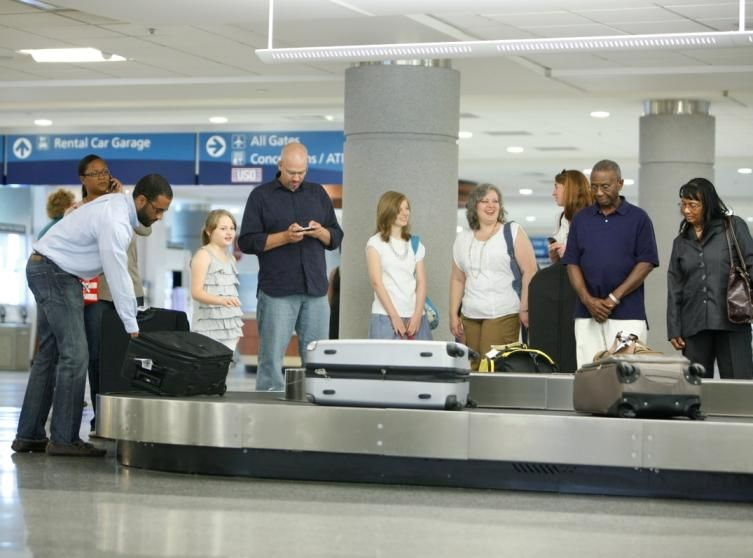

In [17]:
cv2_imshow(image)

**Use the pretrained model to find objects in the image**<br>
The model will find create a bounding box for each object it finds. In fact it may find the same object several times, resulting in multiple bounding boxes around the object.

In [18]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1.0 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
# show timing information on YOLO
print("YOLO took {:.6f} seconds".format(end - start))

YOLO took 4.140742 seconds


**Set up the lists for the bounding boxes, confidences, and classIDs**

In [19]:
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

**Create the lists of boxes, confidences, and class IDs** <br>
These are the bounding boxes that will be added to the image

In [20]:
# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		#====changed this confidence level=====
		if confidence > 0.10:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In [21]:
print(boxes)
print(confidences)
print(classIDs)

[[22, 169, 153, 253], [17, 172, 161, 277], [47, 173, 144, 279], [295, 324, 179, 77], [66, 155, 57, 58], [543, 167, 48, 86], [542, 171, 48, 96], [239, 140, 94, 227], [246, 146, 94, 215], [360, 182, 71, 146], [445, 181, 87, 145], [452, 176, 89, 155], [545, 160, 114, 181], [564, 156, 95, 190], [189, 214, 55, 118], [189, 205, 64, 142], [240, 150, 94, 231], [243, 148, 96, 234], [366, 198, 56, 134], [361, 193, 69, 145], [364, 188, 85, 154], [445, 187, 89, 165], [448, 178, 93, 179], [527, 163, 64, 210], [543, 165, 115, 199], [562, 156, 99, 213], [664, 183, 87, 182], [714, 218, 36, 103], [17, 177, 66, 231], [20, 153, 102, 285], [35, 156, 124, 280], [191, 212, 54, 148], [190, 211, 62, 156], [240, 169, 91, 227], [245, 161, 93, 243], [359, 198, 71, 168], [446, 205, 86, 156], [453, 201, 86, 163], [526, 192, 61, 184], [564, 170, 99, 226], [665, 180, 84, 204], [713, 226, 38, 111], [19, 162, 115, 288], [32, 158, 123, 292], [189, 210, 64, 185], [109, 319, 123, 78], [119, 319, 114, 79], [119, 301, 114,

In [22]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0,1)

**Add the bounding boxes to the image**<br>
Draw the bounding boxes on the image, and the confidence values and add the class ID. <br>
Right now we are keeping every bounding box the model added. As you can see when you draw the image, some of the objects have more than one bounding box around them. This is because the model is detecting the object on different levels. <br>


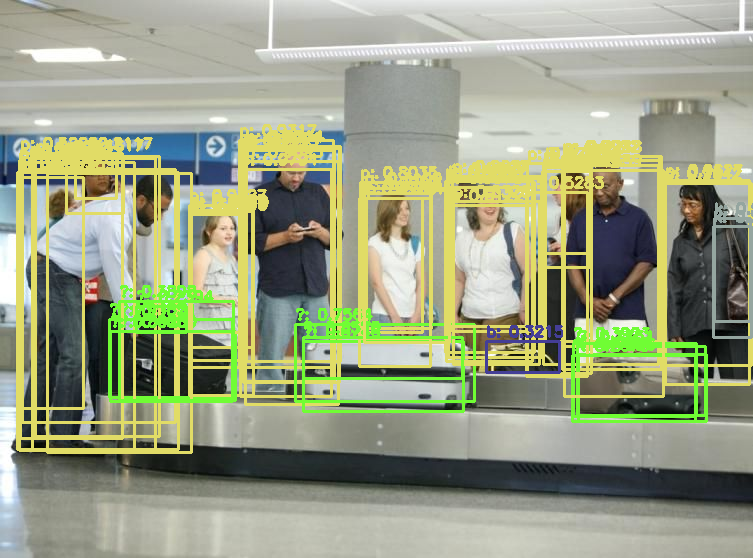

In [23]:
# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, color, 2)
# show the output image
cv2_imshow(image)

In the image below the black box is the ground truth box. The red box is the predicted box. <br>
- If no object exists in the cell, the conﬁdence scores should be zero. <br>
- The conﬁdence score is equal to the intersection over union (IOU) between the predicted box and the ground truth.

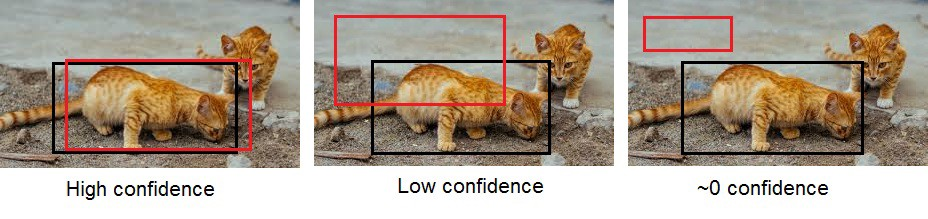

In [24]:
Image("images/confidence.jpeg", width=640)

**Keep only the boxes with the highest confidence**<br>
The model has detected a lot of objects in the image and created a bounding box, a score, and a confidence score for each one. <br>
The model detected some objects more than once. <br>
Let's have the model detect objects again, but this time we'll keep only those boxes that don't overlap and that have a higher confidence level.

In [25]:
# load our input image and grab its spatial dimensions
image = cv2.imread("/content/cloned-repo/yolo-object-detection/images/baggage_claim.jpg")
(H, W) = image.shape[:2]

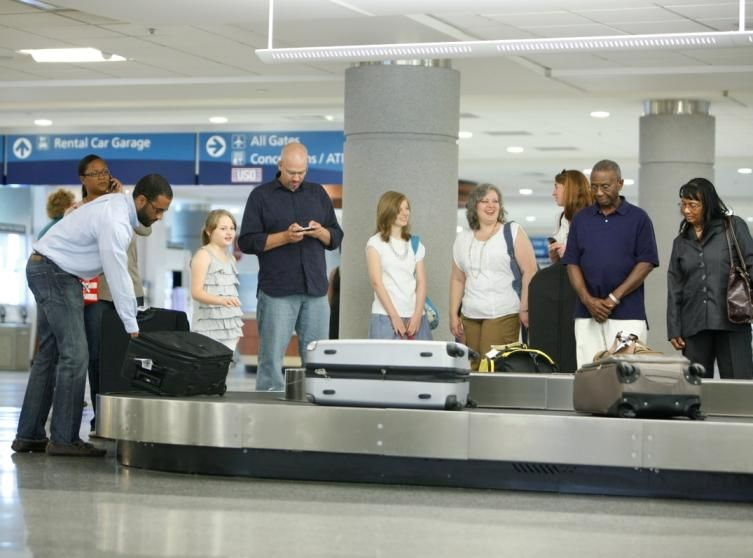

In [26]:
cv2_imshow(image)

**Use the YOLO model to detect objects in the image**

In [27]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
# show timing information on YOLO
print("YOLO took {:.6f} seconds".format(end - start))

YOLO took 1.538393 seconds


**Compile the lists of boxes, confidences, and class IDs**.<br>
But this time, only keep the boxes that have a confidence score higher than 50%

In [28]:
# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		#====changed this confidence level=====
		if confidence > .50:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

**Apply non-maxima suppression** (NMS) to the lists of boxes and confidences. <br>
Remove any boxes that do not meet the threshold for overlap and confidence score.

In [29]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, .50,0.3)

**Add the boxes, confidence scores, and class IDS to the image**

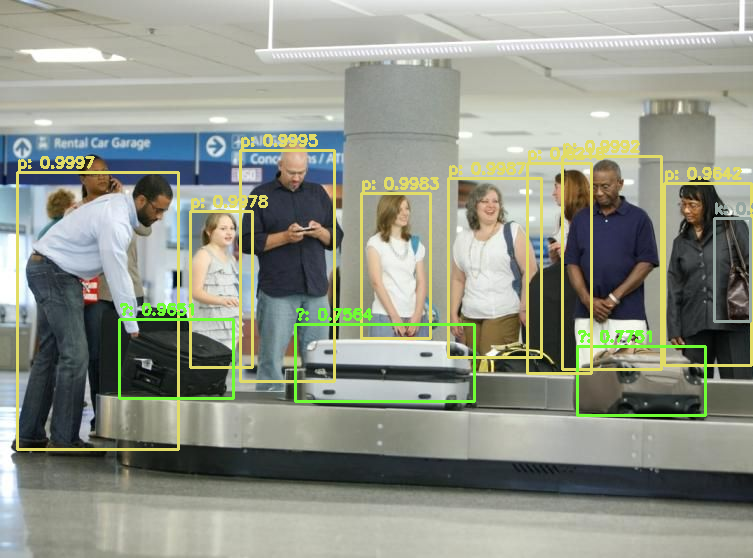

In [30]:
# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, color, 2)
# show the output image
cv2_imshow(image)

Image input Size. The standard input resolution for YOLOv3 is 416 × 416 pixels. Since the original images usually have higher resolution, they need to be down-sampled to an input size of 416 × 416 prior to the input into the network.